<a href="https://colab.research.google.com/github/Munazza-Farees/NITW-SIP2025-Project/blob/main/LNN_LDoS_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install imblearn torch tqdm

In [3]:
# Install required packages

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
import gc
from tqdm import tqdm  # Progress bar
import psutil  # Memory monitoring

# Clear memory
gc.collect()
torch.cuda.empty_cache()

# Check available memory
print(f"CPU Memory Available: {psutil.virtual_memory().available / (1024 ** 2):.2f} MB")
if torch.cuda.is_available():
    print(f"GPU Memory Available: {torch.cuda.memory_available() / (1024 ** 2):.2f} MB")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

CPU Memory Available: 11735.64 MB
Using device: cpu


In [4]:
# Load dataset
URL = '/content/drive/MyDrive/Colab Notebooks/Final_data.csv'
data = pd.read_csv(URL, low_memory=False, dtype={
    'Protocol': 'category',
    'Connection_Patterns': 'category',
    'Traffic_Patterns': 'category'
})

# Print dataset info
print("Features:", data.columns.tolist())
print("Class distribution:", data['Label'].value_counts())

# Handle missing values
data.fillna(data.mean(numeric_only=True), inplace=True)

# Encode categorical features
for col in ['Protocol', 'Connection_Patterns', 'Traffic_Patterns']:
    data[col] = data[col].cat.codes

# Select features and labels
features_to_be_scaled = data.drop(['Source', 'Destination', 'Label'], axis=1)
labels = data['Label']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_to_be_scaled)

# Memory cleanup
# del data, features_to_be_scaled
gc.collect()

Features: ['Time', 'Source', 'Destination', 'Protocol', 'Length', 'src_port', 'dst_port', 'Flow_Duration', 'Total_Packets', 'Total_Bytes', 'Mean_Packet_Size', 'Packet_Rate', 'Byte_Rate', 'Packet_Size_Entropy', 'Inter_Arrival_Time_Entropy', 'Packet_Size_Variance', 'Average_Bytes_Per_Packet', 'Average_Bytes_Per_Flow', 'Flow_Count_Per_Source', 'Packet_Loss_Rate', 'Round_Trip_Time', 'Connection_Patterns', 'Traffic_Patterns', 'Label', 'source_ip_entropy', 'source_port_entropy', 'dest_ip_entropy', 'dest_port_entropy']
Class distribution: Label
normal    1512389
attack     659463
Name: count, dtype: int64


9

In [5]:
!cat /proc/meminfo | grep MemAvailable

MemAvailable:   10505100 kB


In [6]:
# counts = data['Connection_Patterns'].value_counts()
# print(counts)
# counts = data['Traffic_Patterns'].value_counts()
# print(counts)

In [7]:
# Create sequences
seq_len = 15  # Reduced from 20
X_seq, y_seq = [], []
for i in tqdm(range(len(X_scaled) - seq_len), desc="Creating sequences"):
    X_seq.append(X_scaled[i:i + seq_len])
    y_seq.append(labels[i + seq_len])

X_seq = np.array(X_seq, dtype=np.float32)  # Use float32 to save memory
y_seq = np.array(y_seq)

Creating sequences: 100%|██████████| 2171837/2171837 [00:08<00:00, 263447.29it/s]


In [8]:
# Apply SMOTE
# smote = SMOTE(random_state=42, k_neighbors=3)  # Reduced neighbors
# X_reshaped = X_seq.reshape(X_seq.shape[0], -1)
# X_balanced, y_balanced = smote.fit_resample(X_reshaped, y_seq)
# X_balanced = X_balanced.reshape(-1, seq_len, X_seq.shape[2])

In [9]:
# print(f"X_balanced shape: {np.shape(X_balanced)}, dtype: {np.array(X_balanced).dtype}")
# print(f"Estimated memory (MB): {np.array(X_balanced).nbytes} / (1024 ** 2):.2f")

In [10]:
# Split data
# X_train, X_test, y_train, y_test = train_test_split(
#     X_balanced, y_balanced, test_size=0.2, random_state=42
# )
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42
)

# Memory cleanup
# del X_seq, y_seq, X_reshaped, X_balanced, y_balanced
del X_seq, y_seq
gc.collect()

0

In [11]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert to tensors with error handling
device = torch.device('cpu')
try:
    X_train = torch.tensor(X_train, dtype=torch.float32) # Pin for faster GPU transfer
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train_encoded, dtype=torch.float32).unsqueeze(1)
    y_test = torch.tensor(y_test_encoded, dtype=torch.float32).unsqueeze(1)
except RuntimeError as e_cpu:
    print(f"Tensor conversion failed even on CPU: {e_cpu}")
    raise e_cpu


# Move to device (This will now happen during training loop batch-wise)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_train shape: torch.Size([1737469, 15, 25]), y_train shape: torch.Size([1737469, 1])


In [12]:
from torch.utils.data import TensorDataset, DataLoader

# Ensure shapes match - these should now be torch tensors
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Create datasets
# These should now be torch tensors due to the conversion above
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders
batch_size = 128
# Ensure num_workers=0 for Colab or similar environments to avoid multiprocessing issues
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# Memory cleanup - these variables are now likely consumed by the DataLoaders if pin_memory=True
# Or just references to the tensors
del X_train, y_train
gc.collect()

X_train shape: torch.Size([1737469, 15, 25]), y_train shape: torch.Size([1737469, 1])
X_test shape: torch.Size([434368, 15, 25]), y_test shape: torch.Size([434368, 1])


0

In [13]:
class LiquidTimeStep(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LiquidTimeStep, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W_in = nn.Linear(input_size, hidden_size)
        self.W_hid = nn.Linear(hidden_size, hidden_size)
        self.tau = nn.Parameter(torch.rand(hidden_size).clamp(min=0.5, max=2.0))  # Random tau
        # self.tau = nn.Parameter(torch.ones(hidden_size) * 1.0)  # Simplified tau
        self.norm = nn.LayerNorm(hidden_size)  # Add normalization

    def forward(self, x, h):
        dx = torch.tanh(self.W_in(x) + self.W_hid(h))
        h_new = h + (dx - h) / self.tau
        h_new = self.norm(h_new)
        return h_new

class LNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.liquid_layers = nn.ModuleList([
            LiquidTimeStep(input_size if i == 0 else hidden_size, hidden_size)
            for i in range(num_layers)
        ])
        self.dropout = nn.Dropout(0.2)  # Add dropout
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
        for t in range(seq_len):
            x_t = x[:, t, :]
            for i in range(self.num_layers):
                h[i] = self.liquid_layers[i](x_t, h[i])
                x_t = h[i]
        output = self.output_layer(h[-1])
        output = self.sigmoid(output)
        return output

# Hyperparameters
input_size = 25  # Number of features
hidden_size = 64  # Increased for better capacity
output_size = 1  # Binary classification (LDoS or not)
num_layers = 2

# Initialize model, loss, and optimizer
model = LNN(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)  # AdamW with L2

In [14]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import GradScaler, autocast

# Training setup
num_epochs = 10  # Increased for convergence
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
best_loss = float('inf')
patience, counter = 5, 0

y_train_labels_tensor = train_dataset.tensors[1]

# Calculate the number of positive samples (assuming positive class is encoded as 1)
num_positive = torch.sum(y_train_labels_tensor)
num_samples = len(train_dataset)

# Class weights for imbalance
pos_weight = torch.tensor([num_samples / (num_positive + 1e-10)]).to(device)
criterion = nn.BCELoss(weight=pos_weight)

from torch.cuda.amp import GradScaler, autocast

# Mixed precision scaler
scaler = GradScaler(enabled=torch.cuda.is_available())

# Training loop
for epoch in range(num_epochs):  # Fixed range syntax
    model.train()
    total_loss = 0
    num_batches = 0
    for batch_X, batch_y in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', disable=False):
        batch_X, batch_y = batch_X.to(device, non_blocking=True), batch_y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=torch.cuda.is_available()):
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
        num_batches += 1

    avg_loss = total_loss / num_batches
    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
        torch.save(model.state_dict(), 'best_lnn_ldos.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

# Memory cleanup
torch.save(model, "best_lnn_ldos.pth")
torch.cuda.empty_cache()

/tmp/ipython-input-14-2928756355.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())
Epoch 1/10:   0%|          | 0/13574 [00:00<?, ?it/s]/tmp/ipython-input-14-2928756355.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
Epoch 1/10: 100%|██████████| 13574/13574 [06:01<00:00, 37.58it/s]


Epoch 1/10, Loss: 0.4374, LR: 0.000976


Epoch 2/10: 100%|██████████| 13574/13574 [06:11<00:00, 36.52it/s]


Epoch 2/10, Loss: 0.4230, LR: 0.000905


Epoch 3/10: 100%|██████████| 13574/13574 [06:12<00:00, 36.49it/s]


Epoch 3/10, Loss: 0.4190, LR: 0.000794


Epoch 4/10: 100%|██████████| 13574/13574 [06:07<00:00, 36.95it/s]


Epoch 4/10, Loss: 0.4162, LR: 0.000655


Epoch 5/10: 100%|██████████| 13574/13574 [06:05<00:00, 37.11it/s]


Epoch 5/10, Loss: 0.4135, LR: 0.000501


Epoch 6/10: 100%|██████████| 13574/13574 [06:06<00:00, 36.99it/s]


Epoch 6/10, Loss: 0.4111, LR: 0.000346


Epoch 7/10: 100%|██████████| 13574/13574 [06:04<00:00, 37.26it/s]


Epoch 7/10, Loss: 0.4089, LR: 0.000207


Epoch 8/10: 100%|██████████| 13574/13574 [06:03<00:00, 37.33it/s]


Epoch 8/10, Loss: 0.4069, LR: 0.000096


Epoch 9/10: 100%|██████████| 13574/13574 [06:05<00:00, 37.16it/s]


Epoch 9/10, Loss: 0.4053, LR: 0.000025


Epoch 10/10: 100%|██████████| 13574/13574 [06:08<00:00, 36.84it/s]

Epoch 10/10, Loss: 0.4042, LR: 0.000001


In [15]:
# torch.save(model, "best_lnn_ldos.pth")
# model = LNN(input_size, hidden_size, output_size, num_layers).to(device)
# model.load_state_dict(torch.load('best_lnn_ldos.pth', map_location=device))

Evaluating: 100%|██████████| 3394/3394 [00:38<00:00, 88.60it/s]


Test Accuracy: 0.8658
Precision: 0.8592
Recall: 0.9658
F1 Score: 0.9094
ROC-AUC: 0.9266


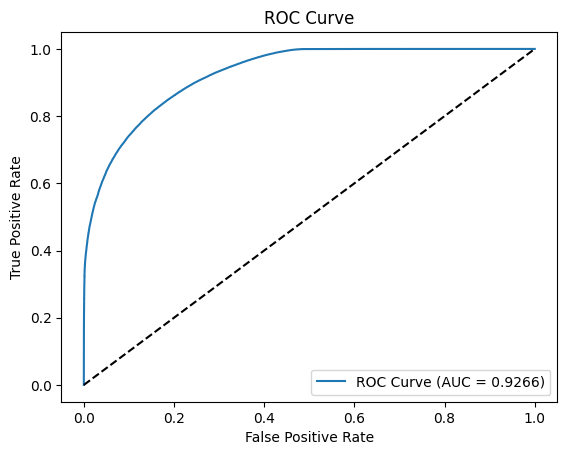

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Evaluation
model = LNN(input_size, hidden_size, output_size, num_layers).to(device)

model = torch.load('best_lnn_ldos.pth', map_location=device, weights_only=False)
model.eval()

all_outputs, all_labels = [], []
with torch.no_grad():
    for batch_X, batch_y in tqdm(test_loader, desc="Evaluating"):
        outputs = model(batch_X.to(device))
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(batch_y.numpy())
all_outputs = np.concatenate(all_outputs)
all_labels = np.concatenate(all_labels)
predictions = (all_outputs >= 0.5).astype(np.float32)

# Metrics
accuracy = accuracy_score(all_labels, predictions)
precision = precision_score(all_labels, predictions)
recall = recall_score(all_labels, predictions)
f1 = f1_score(all_labels, predictions)
roc_auc = roc_auc_score(all_labels, all_outputs)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_outputs)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('roc_curve.png')
plt.show()

In [24]:
# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

y_train_labels_tensor = train_dataset.tensors[1]

num_positive = torch.sum(y_train_labels_tensor)
num_samples = len(train_dataset)

# Class weights for imbalanced data
pos_weight = torch.tensor([num_samples / (num_positive + 1e-10)]).to(device)  # Weight for positive class
criterion = nn.BCELoss(weight=pos_weight)

In [28]:
# Load the model
model = torch.load('best_lnn_ldos.pth', map_location=device, weights_only=False)
model.eval()

# Example inference on new data
new_data = torch.FloatTensor(X_test[:1]).to(device)  # Example: first test sample
with torch.no_grad():
    prediction = model(new_data)
    is_ldos = "LDoS Attack" if prediction >= 0.5 else "Benign"
    print(f"Prediction: {is_ldos}, Probability: {prediction.item():.4f}")

Prediction: LDoS Attack, Probability: 0.5822


Top 10 features:
 Inter_Arrival_Time_Entropy    0.179866
Round_Trip_Time               0.174266
src_port                      0.159918
Packet_Size_Variance          0.159907
Total_Bytes                   0.079951
Connection_Patterns           0.043091
Total_Packets                 0.041113
Average_Bytes_Per_Flow        0.040113
Average_Bytes_Per_Packet      0.033757
Traffic_Patterns              0.028741
dtype: float64


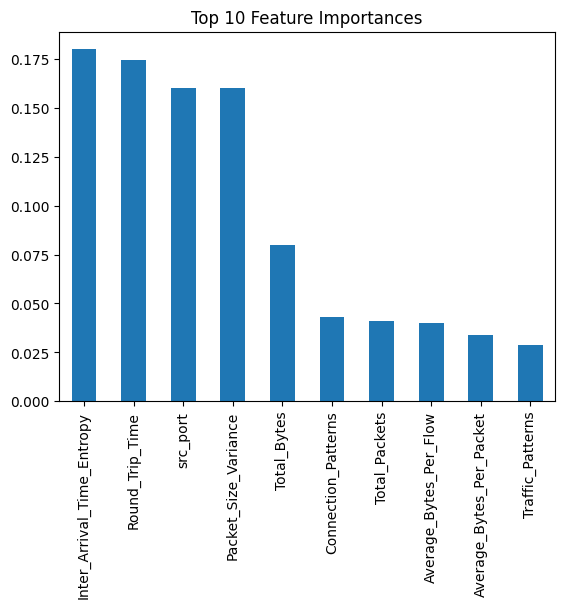

In [29]:
from sklearn.ensemble import RandomForestClassifier

# Feature importance
rf = RandomForestClassifier(n_estimators=50, random_state=42)  # Reduced trees
rf.fit(X_scaled, labels)

feature_names = features_to_be_scaled.columns
feature_importance = pd.Series(rf.feature_importances_, index=feature_names)
print("Top 10 features:\n", feature_importance.nlargest(10))

# Plot feature importance
feature_importance.nlargest(10).plot(kind='bar')
plt.title('Top 10 Feature Importances')
plt.savefig('feature_importance.png')
plt.show()

In [ ]:
# # Mixed Precision Training (Optional, for GPU)

# from torch.cuda.amp import GradScaler, autocast

# # Training with mixed precision
# scaler = GradScaler()
# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0
#     num_batches = 0
#     for batch_X, batch_y in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
#         batch_X, batch_y = batch_X.to(device), batch_y.to(device)
#         optimizer.zero_grad(set_to_none=True)
#         with autocast():
#             outputs = model(batch_X)
#             loss = criterion(outputs, batch_y)
#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.step(optimizer)
#         scaler.update()
#         total_loss += loss.item()
#         num_batches += 1

#     avg_loss = total_loss / num_batches
#     scheduler.step()
#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

#     if avg_loss < best_loss:
#         best_loss = avg_loss
#         counter = 0
#         torch.save(model.state_dict(), 'best_lnn_mixed.pth')
#     else:
#         counter += 1
#         if counter >= patience:
#             print("Early stopping triggered")
#             break